In [3]:
import os
import itertools
#hi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from joblib import Parallel, delayed
from sklearn import metrics
from aequitas.group import Group

from autodefer.models import haic
from autodefer.utils import thresholding as t, plotting
import pickle

import json

sns.set_style('whitegrid')

MODELS_PATH = './models/'

cfg_path = 'cfg.yaml'
with open(cfg_path, 'r') as infile:
    cfg = yaml.safe_load(infile)


data_cfg_path = '../data/dataset_cfg.yaml'

with open(data_cfg_path, 'r') as infile:
    data_cfg = yaml.safe_load(infile)


cat_dict = data_cfg['categorical_dict']

LABEL_COL = 'fraud_label'
PROTECTED_COL = 'customer_age'
CATEGORICAL_COLS = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'assignment']
TIMESTAMP_COL = 'month'
SCORE_COL = 'model_score'
BATCH_COL = 'batch'
ASSIGNMENT_COL = 'assignment'
DECISION_COL = 'decision'


expert_ids_path = '../experts/expert_info/expert_ids.yaml'

with open(expert_ids_path, 'r') as infile:
    EXPERT_IDS = yaml.safe_load(infile)

# Expert behavior model performance

In [4]:
RMAs = dict()

for train_env in os.listdir(MODELS_PATH):
    RMAs[train_env] = haic.assigners.RiskMinimizingAssigner(
        expert_ids=EXPERT_IDS,
        outputs_dir=f'{MODELS_PATH}{train_env}/',
    )
    calibrator_path = f'{MODELS_PATH}{train_env}/calibrator.pickle'
    RMAs[train_env].load(CATEGORICAL_COLS, SCORE_COL, ASSIGNMENT_COL, calibrator_path, cat_dict)

In [5]:
test = pd.read_parquet('../testbed/test/test.parquet')
test_expert_pred = pd.read_parquet('../testbed/test/test_expert_pred.parquet')

def cat_checker(data, features, cat_dict):
    new_data = data.copy()
    for feature in features:
        if new_data[feature].dtype != 'category':
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
        elif new_data[feature].dtype.categories.to_list() != cat_dict[feature]:
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
    
    return new_data


cat_dict['assignment'] = EXPERT_IDS['human_ids'] + EXPERT_IDS['model_ids']

test = cat_checker(test, data_cfg['data_cols']['categorical'], cat_dict)

def get_outcome(label, pred):
    if pred == 1:
        if label == 1:
            o = 'tp'
        elif label == 0:
            o = 'fp'
    elif pred == 0:
        if label == 1:
            o = 'fn'
        elif label == 0:
            o = 'tn'
    return o

test['assignment'] = 'blank'


test = test.drop(columns = ['fraud_label', 'month'])
roc_curves = dict()

test = pd.read_parquet('../testbed/test/test.parquet')
test_expert_pred = pd.read_parquet('../testbed/test/test_expert_pred.parquet')

test_fp = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
test_fn = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
test_tp = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
test_tn = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
outcomes_df = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])

for expert in EXPERT_IDS['human_ids']:
    test_tn.loc[:,expert] = ((test['fraud_label'] == 0) & (test_expert_pred[expert] == 0))
    test_tp.loc[:,expert] = ((test['fraud_label'] == 1) & (test_expert_pred[expert] == 1))
    test_fn.loc[:,expert] = ((test['fraud_label'] == 1) & (test_expert_pred[expert] == 0))
    test_fp.loc[:,expert] = ((test['fraud_label'] == 0) & (test_expert_pred[expert] == 1))

outcomes_df[test_tn] = 'tn'
outcomes_df[test_tp] = 'tp'
outcomes_df[test_fn] = 'fn'
outcomes_df[test_fp] = 'fp'

with open('calibrated_predictions.pkl', 'rb') as fp:
        pred_probas = pickle.load(fp)

In [6]:
if os.path.isfile('roc_curves_info.pkl'):
    with open('roc_curves_info.pkl', 'rb') as fp:
        roc_curves = pickle.load(fp)
else:
    for env_id in os.listdir(MODELS_PATH):
        print(env_id)
        curves = dict()
        total_outcomes = []
        total_pred_proba_fp = []
        total_pred_proba_fn = []
        i=0
        for expert in EXPERT_IDS['human_ids']:
            outcomes = outcomes_df[expert]

            total_outcomes.append(outcomes.to_numpy().squeeze())

            test['assignment'] = expert
            
            test = cat_checker(test, data_cfg['data_cols']['categorical'] + ['assignment'], cat_dict)

            pred_proba_fp = pred_probas[env_id][expert]['fp']
            pred_proba_fn = pred_probas[env_id][expert]['fn']
            pred_error = pred_proba_fp + pred_proba_fn

            total_pred_proba_fp.append(pred_proba_fp)
            total_pred_proba_fn.append(pred_proba_fn)

            fp_fpr, fp_tpr,_ = metrics.roc_curve(y_true = (outcomes == 'fp').astype(int), y_score = pred_proba_fp.squeeze())
            fn_fpr, fn_tpr,_ = metrics.roc_curve(y_true = (outcomes == 'fn').astype(int), y_score = pred_proba_fn.squeeze())
            e_fpr, e_tpr,_ = metrics.roc_curve(y_true = ((outcomes == 'fp') | (outcomes == 'fn')).astype(int), y_score = pred_error.squeeze())
            fn_auc = metrics.roc_auc_score(y_true = (outcomes == 'fn').astype(int), y_score = pred_proba_fn.squeeze())
            fp_auc = metrics.roc_auc_score(y_true = (outcomes == 'fp').astype(int),  y_score = pred_proba_fp.squeeze())
            e_auc = metrics.roc_auc_score(y_true = ((outcomes == 'fp') | (outcomes == 'fn')).astype(int), y_score = pred_error.squeeze())

            curves[expert]= {'fp_fpr': fp_fpr,
                            'fp_tpr': fp_tpr,
                            'fn_fpr': fn_fpr,
                            'fn_tpr': fn_tpr,
                            'fn_auc': fn_auc,
                            'fp_auc': fp_auc,
                            'e_tpr': e_tpr,
                            'e_fpr': e_fpr,
                            'e_auc': e_auc}
            i+=1
            
        
        total_pred_proba_fp = np.concatenate(total_pred_proba_fp)
        total_pred_proba_fn = np.concatenate(total_pred_proba_fn)
        total_outcomes = np.concatenate(total_outcomes)
        fp_fpr, fp_tpr,_ = metrics.roc_curve(y_true = (total_outcomes == 'fp').astype(int), y_score = total_pred_proba_fp)
        fn_fpr, fn_tpr,_ = metrics.roc_curve(y_true = (total_outcomes == 'fn').astype(int), y_score = total_pred_proba_fn)
        fn_auc = metrics.roc_auc_score(y_true = (total_outcomes == 'fn').astype(int), y_score =total_pred_proba_fn)
        fp_auc = metrics.roc_auc_score(y_true = (total_outcomes == 'fp').astype(int), y_score = total_pred_proba_fp)
        curves['all']= {'fp_fpr': fp_fpr,
                            'fp_tpr': fp_tpr,
                            'fn_fpr': fn_fpr,
                            'fn_tpr': fn_tpr,
                            'fn_auc': fn_auc,
                            'fp_auc': fp_auc,
                            }
        roc_curves[env_id] = curves
    with open('roc_curves_info.pkl', 'wb') as fp:
        pickle.dump(roc_curves, fp)

small-1_regular
small-2_regular
small-3_regular
small-4_regular
small-5_regular


In [7]:
pal = sns.color_palette(['C0','C1','C2', 'C3'])
pal = pal.as_hex()

dict_keys(['small-1_regular', 'small-2_regular', 'small-3_regular', 'small-4_regular', 'small-5_regular'])


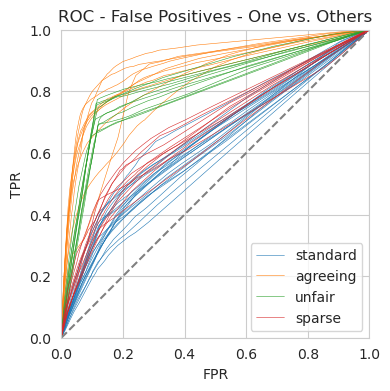

In [8]:


f, ax = plt.subplots(figsize=(4, 4))

print(roc_curves.keys())
train_env = 'small-1_regular'
exp = roc_curves[train_env]


reg_counter = 0
ma_counter = 0
un_counter = 0
sp_counter = 0
for expert in EXPERT_IDS['human_ids']:
    setlabel = None
    if expert.split('#')[0] == 'standard':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    elif expert.split('#')[0] == 'sparse':
        color = pal[3]
        if(sp_counter == 0):
            setlabel = 'sparse'
            sp_counter += 1
    plt.plot(exp[expert]['fp_fpr'],exp[expert]['fp_tpr'], c = color, linewidth = 0.4, label = setlabel)


plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - False Positives - One vs. Others')
plt.legend()
plt.savefig("ROC_FP_OvO.pdf", format="pdf", bbox_inches="tight")
plt.show()

dict_keys(['small-1_regular', 'small-2_regular', 'small-3_regular', 'small-4_regular', 'small-5_regular'])


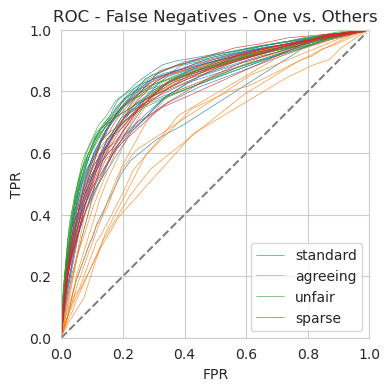

In [9]:


f, ax = plt.subplots(figsize=(4, 4))

print(roc_curves.keys())
train_env = 'small-1_regular'
exp = roc_curves[train_env]


reg_counter = 0
ma_counter = 0
un_counter = 0
sp_counter = 0
for expert in EXPERT_IDS['human_ids']:
    setlabel = None
    if expert.split('#')[0] == 'standard':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    elif expert.split('#')[0] == 'sparse':
        color = pal[3]
        if(sp_counter == 0):
            setlabel = 'sparse'
            sp_counter += 1
    plt.plot(exp[expert]['fn_fpr'],exp[expert]['fn_tpr'], c = color, linewidth = 0.4, label = setlabel)


plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - False Negatives - One vs. Others')
plt.legend()
plt.savefig("ROC_FN_OvO.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [10]:
hem = pd.DataFrame(columns = ['training_seed', 'expert', 'fn_auc', 'fp_auc', 'e_auc'])

for env_id in roc_curves:
    for expert in roc_curves[env_id]:
        if expert == 'all':
            continue
        hem = hem.append(pd.Series([env_id, expert, roc_curves[env_id][expert]['fn_auc'],roc_curves[env_id][expert]['fp_auc'], roc_curves[env_id][expert]['e_auc']], index = hem.columns), ignore_index=True)

In [11]:
hem.groupby(by = ['expert']).mean().reset_index().set_index('expert').loc[test_expert_pred.columns.drop('model#0'),:]

,fn_auc,fp_auc,e_auc
standard#0,0.833190,0.647938,0.682107
standard#1,0.837664,0.606319,0.646141
standard#2,0.843649,0.609458,0.632715
standard#3,0.799261,0.586798,0.602150
standard#4,0.846163,0.607347,0.633151
standard#5,0.814695,0.655723,0.677260
standard#6,0.856606,0.572399,0.631072
standard#7,0.823624,0.662737,0.680056
standard#8,0.834683,0.659487,0.686824
standard#9,0.847387,0.621242,0.673820


In [12]:
l2a_fp_pred = pd.DataFrame(index = test.index, columns = test_expert_pred.columns.drop('model#0') )
l2a_fn_pred = pd.DataFrame(index = test.index, columns = test_expert_pred.columns.drop('model#0') )

In [13]:
costs = dict()
for seed in pred_probas:

    for expert in test_expert_pred.columns.drop('model#0').to_list():
        l2a_fp_pred[expert] = pred_probas[seed][expert]['fp']
        l2a_fn_pred[expert] = pred_probas[seed][expert]['fn']

    l = 0.057
    costs[seed] = l*l2a_fp_pred + l2a_fn_pred

In [14]:
if os.path.isfile('ova_predictions.pkl'):
    with open('ova_predictions.pkl', 'rb') as fp:
        ova_preds = pickle.load(fp)

In [15]:
scores_ = []


for seed, seed_ova in zip(costs.keys(), ova_preds.keys()):
    scores = pd.DataFrame(index = test.index, columns = ['hem','ova','label'])
    for i in costs[seed].index:
        cost_vec = costs[seed].loc[i,:]
        #l2a
        expert = cost_vec.index[cost_vec.argmin()]
        label =test.loc[i,'fraud_label']
        pred = test_expert_pred.loc[i,expert]
        if pred == label:
            scores.loc[i,'hem'] = 1
        else:
            scores.loc[i,'hem'] = 0

        #ova
    for i in ova_preds[seed_ova].index:
        ova_vec = ova_preds[seed_ova].loc[i,:]
        #l2a
        label =test.loc[i,'fraud_label']
        expert = ova_vec.index[ova_vec.argmax()]
        pred = test_expert_pred.loc[i,expert]
        if pred == label:
            scores.loc[i,'ova'] = 1
        else:
            scores.loc[i,'ova'] = 0
    
    scores['label'] = test['fraud_label']
    scores_.append(scores)



In [16]:
b = pd.concat(scores_)
b.loc[b['label'] == 0].mean()


hem      0.978050
ova      0.981703
label    0.000000
dtype: float64

In [17]:
b.loc[b['label'] == 1].mean()

hem      0.625910
ova      0.526331
label    1.000000
dtype: float64

In [18]:
b.mean()

hem      0.972857
ova      0.974988
label    0.014746
dtype: float64

In [19]:
scores_.mean()

AttributeError: 'list' object has no attribute 'mean'